In [16]:
import gc
import os
import warnings
import numpy as np
import pandas as pd
from scipy.stats.mstats import winsorize
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
import bl_opt
import pdb

gc.collect()
warnings.filterwarnings('ignore')

In [17]:
def filter_by_marketcap(returns_df, cap_df, start, end, n_assets):
    current_caps = cap_df.iloc[start]
    valid_caps = current_caps.dropna()
    temp_cols = valid_caps.sort_values(
        ascending=False).head(100).index.tolist()
    returns_slice = returns_df.loc[:, temp_cols].iloc[start:2*end-start]
    returns_notna = returns_slice.dropna(axis=1, how='any')
    clean_caps = current_caps[returns_notna.columns].sort_values(
        ascending=False)
    final_cols = clean_caps.head(n_assets).index
    returns_clean = returns_df.loc[:, temp_cols].iloc[start:end]
    final_returns = returns_clean[final_cols]
    current_caps = cap_df.loc[final_returns.index[0]]
    final_market_caps = current_caps[final_cols]

    return final_returns, final_market_caps


class DynamicSlidingWindowBL:

    def __init__(self, n_assets=10, initial_window=60, eta=0.95, h=0.1, c_minus=0.9, c_plus=1.1, risk_aversion=1.0):
        self.n_assets = n_assets
        self.M = initial_window
        self.eta = eta
        self.h = h
        self.c_minus = c_minus
        self.c_plus = c_plus
        self.risk_aversion = risk_aversion
        # Results storage
        self.expected_returns = []
        self.portfolio_weights = {}
        self.portfolio_volatilities = []
        self.window_sizes = []
        self.market_returns = []
        self.bl_returns = []
        self.views_history = []

    def generate_random_data(self, n_periods=1000, n_factors=5):
        """Generate random market data"""
        np.random.seed(42)

        # Generate factor data (AR(1) process)
        factors = np.zeros((n_periods, n_factors))
        for i in range(n_factors):
            factors[0, i] = np.random.normal(0, 0.02)
            for t in range(1, n_periods):
                factors[t, i] = 0.9 * factors[t-1, i] + \
                    np.random.normal(0, 0.02)

        # Generate asset returns (factor model + noise)
        beta = np.random.normal(0, 0.5, (self.n_assets, n_factors))
        alpha = np.random.normal(0.001, 0.002, self.n_assets)

        returns = np.zeros((n_periods, self.n_assets))
        for t in range(n_periods):
            returns[t] = alpha + factors[t] @ beta.T + \
                np.random.normal(0, 0.02, self.n_assets)

        # Generate price data for PyPortfolioOpt
        prices = np.zeros((n_periods, self.n_assets))
        prices[0] = 100  # Initial price
        for t in range(1, n_periods):
            prices[t] = prices[t-1] * (1 + returns[t])

        # Convert to DataFrame
        price_df = pd.DataFrame(prices,
                                columns=[f'Asset_{i+1}' for i in range(self.n_assets)])

        # Generate time-varying market caps
        # Initial market caps (random distribution)
        initial_caps = np.random.dirichlet(np.ones(self.n_assets)) * 1000000

        # Market cap evolution (follows price changes with some noise)
        cap_df = np.zeros((n_periods, self.n_assets))
        cap_df[0] = initial_caps

        for t in range(1, n_periods):
            # Market cap changes follow price changes with some additional noise
            price_change = prices[t] / prices[t-1]
            cap_change = price_change * \
                (1 + np.random.normal(0, 0.01, self.n_assets))  # Add some noise
            cap_df[t] = cap_df[t-1] * cap_change

        # Convert to DataFrame
        cap_df = pd.DataFrame(cap_df,
                              columns=[f'Asset_{i+1}' for i in range(self.n_assets)])

        return returns, factors, price_df, cap_df

    def calculate_views_from_factors(self, factors, returns):
        """Calculate views using factor model"""
        alphas = []
        betas = []

        for i in range(self.n_assets):
            # Elastic Net regression
            model = ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=1000)

            scaler_X = StandardScaler()
            scaler_y = StandardScaler()

            X_scaled = scaler_X.fit_transform(factors)
            y_scaled = scaler_y.fit_transform(
                returns[:, i].reshape(-1, 1)).ravel()

            model.fit(X_scaled, y_scaled)

            beta = model.coef_ / scaler_X.scale_ * scaler_y.scale_
            alpha = scaler_y.mean_[0] - np.sum(beta * scaler_X.mean_)

            alphas.append(alpha)
            betas.append(beta)

        alphas = np.array(alphas)
        betas = np.array(betas)

        # Views setup
        P = np.eye(self.n_assets)  # Direct views for each asset
        # Factor model based expected returns
        Q = alphas + np.mean(factors @ betas.T, axis=0)

        # Views uncertainty
        Omega = np.diag(np.var(returns, axis=0)) * 0.025

        return P, Q, Omega

    def calculate_portfolio_volatility(self, weights, returns):
        """Calculate portfolio volatility"""
        portfolio_returns = returns @ weights
        volatility = np.std(portfolio_returns)
        return volatility

    def adjust_window_size(self, current_vol, previous_vol):
        """Dynamically adjust window size based on volatility"""
        if current_vol >= (1 + self.h) * previous_vol:
            # Increase volatility -> decrease window size
            self.M = int(self.c_minus * self.M)
        elif current_vol <= (1 - self.h) * previous_vol:
            # Decrease volatility -> increase window size
            self.M = int(self.c_plus * self.M)

        # Limit window size
        self.M = max(15, min(self.M, 200))

    def dict2numpy(self, w_bl, mu_bl):
        # Convert to numpy arrays
        # Handle OrderedDict or dict for weights
        if isinstance(w_bl, dict):
            w_bl = np.array(list(w_bl.values()))
        elif hasattr(w_bl, 'values'):
            w_bl = w_bl.values
            if hasattr(w_bl, '__iter__') and not isinstance(w_bl, np.ndarray):
                w_bl = np.array(list(w_bl))
            else:
                w_bl = np.array(w_bl)
        else:
            w_bl = np.array(w_bl)

        # Handle OrderedDict or dict for returns
        if isinstance(mu_bl, dict):
            mu_bl = np.array(list(mu_bl.values()))
        elif hasattr(mu_bl, 'values'):
            mu_bl = mu_bl.values
            if hasattr(mu_bl, '__iter__') and not isinstance(mu_bl, np.ndarray):
                mu_bl = np.array(list(mu_bl))
            else:
                mu_bl = np.array(mu_bl)
        else:
            mu_bl = np.array(mu_bl)

        return w_bl, mu_bl

    def run_algorithm(self, returns_df, cap_df, factor_df, n_iterations=50):
        """Run the complete algorithm"""
        n_periods = len(returns_df)
        t = self.M

        factors = factor_df.values
        tic_df = pd.DataFrame()

        for iteration in range(n_iterations):
            if t >= n_periods:
                break

            # 매 시점마다 시총 상위 20개 자산 선택
            returns, current_market_caps = filter_by_marketcap(
                returns_df, cap_df, t-self.M, t, self.n_assets)

            date = str(returns.index[-1])  # 현재 시점
            tic_df[date] = current_market_caps.index

            # Step 1: Data Collection - 윈도우 크기 M만큼의 데이터 사용
            r_data = returns.values  # M 크기의 수익률 데이터
            f_data = factors[t-self.M:t]  # M 크기의 팩터 데이터

            # Step 2: Calculate covariance matrix using PyPortfolioOpt

            cov_matrix = returns.cov()
            # Step 3: Calculate market implied returns using PyPortfolioOpt
            # Get current market caps from cap_df
            # Use market cap from previous period

            # print(current_market_caps)
            pi = bl_opt.Pi(
                current_market_caps, risk_aversion=self.risk_aversion, cov_matrix=cov_matrix
            )

            # Step 4: Calculate views using factor model
            P, Q, Omega = self.calculate_views_from_factors(f_data, r_data)

            # print(pi.values)

            # Step 5: Apply Black-Litterman model using PyPortfolioOpt
            # mu_bl, sigma_bl = bl_opt.posterior_dist(
            #     cov_matrix, pi, P=P, Q=Q, Omega=Omega, tau=0.025)
            mu_bl, sigma_bl = bl_opt.posterior_dist_elastic(
                cov_matrix, pi, P=P, Q=Q, Omega=Omega, tau=0.025, lambda1=0.5, lambda2=0.5)

            # Step 6: Get Black-Litterman returns and weights

            rrT = np.outer(r_data[-1], r_data[-1])
            S_bl = self.eta * sigma_bl + (1 - self.eta) * rrT
            # cov_matrix = risk_models.exp_cov(price_data, returns_data=True)

            # *** NaN 값 & inf 처리
            mu_mean = np.nanmean(mu_bl)
            mu_bl = np.nan_to_num(mu_bl, nan=mu_mean, posinf=0.0, neginf=0.0)
            S_bl = np.nan_to_num(S_bl, nan=0.0, posinf=0.0, neginf=0.0)

            # 2)*** 최적화: 공매도 금지 (short-sale not allowed)
            # w_bl = bl_opt.max_sharpe_opt(mu_bl, S_bl, risk_free_rate= 0.0, long_only=True)
            w_bl = bl_opt.mean_var_opt(
                mu_bl, S_bl, risk_aversion=self.risk_aversion, long_only=True, weight_bounds=(0.0, 0.25))

            # Step 7: Execute transactions and evaluate volatility
            # 다음 윈도우의 수익률로 포트폴리오 성과 평가
            if t + self.M < n_periods:
                next_returns = returns_df.iloc[t:t +
                                               self.M-1][current_market_caps.index]
                current_vol = self.calculate_portfolio_volatility(
                    w_bl, next_returns.values)
            else:
                # 마지막 윈도우인 경우 현재 윈도우로 평가
                current_vol = self.calculate_portfolio_volatility(w_bl, r_data)

            # Step 8: Dynamic window size adjustment
            if iteration > 0:
                previous_vol = self.portfolio_volatilities[-1]
                self.adjust_window_size(current_vol, previous_vol)

            # Store results
            self.expected_returns.append(mu_bl.copy())
            self.portfolio_weights[date] = w_bl.copy()
            self.portfolio_volatilities.append(current_vol)
            self.window_sizes.append(self.M)
            self.market_returns.append(pi.copy())
            self.bl_returns.append(mu_bl.copy())
            self.views_history.append(Q.copy())

            # Step 9: Update time
            t += self.M

            if iteration % 10 == 0:
                print(
                    f"Iteration {iteration}: Window size = {self.M}, Volatility = {current_vol:.4f}")

        print(f"Algorithm completed: {len(self.portfolio_weights)} iterations")
        tic_df.T.index = pd.to_datetime(tic_df.T.index)
        return tic_df.T

    def get_results_summary(self):
        """Get algorithm results summary"""
        print(f"\n=== Algorithm Results Summary ===")
        print(f"Final window size: {self.M}")
        print(
            f"Average portfolio volatility: {np.mean(self.portfolio_volatilities):.4f}")

        print(f"Volatility std: {np.std(self.portfolio_volatilities):.4f}")


In [18]:
# dsa = DynamicSlidingWindowBL(
#     n_assets=20,           # 10 assets
#     initial_window=60,     # Initial window size 60
#     eta=0.95,              # EWMA decay factor
#     h=0.1,                 # Volatility threshold for window adjustment
#     risk_aversion=3.0,     # Risk aversion parameter
#     c_minus=0.9,           # Window decrease factor
#     c_plus=1.1             # Window increase factor
# )
# sim_returns, sim_factors, sim_price_df, sim_cap_df = dsa.generate_random_data(
#     n_periods=1000, n_factors=5)

# print(f"sim_returns.shape: {sim_returns.shape}")
# print(f"sim_factors.shape: {sim_factors.shape}")
# print(f"sim_price_df.shape: {sim_price_df.shape}")
# print(f"sim_cap_df.shape: {sim_cap_df.shape}")

# dsa.run_algorithm(pd.DataFrame(sim_returns, index=sim_price_df.index, columns=sim_price_df.columns), pd.DataFrame(sim_factors),
#                   sim_cap_df, n_iterations=30)

# # Display results
# dsa.get_results_summary()

In [19]:
returns_df = pd.read_parquet('data/returns_df.parquet')
rank_df = pd.read_parquet('data/rank_df.parquet')
cap_df = pd.read_parquet('data/cap_df.parquet')

freq = 'D'

factor_df = pd.read_csv('data/factors.csv', index_col=0)
factor_df.index = factor_df.index.astype(str)
factor_df.index = pd.to_datetime(factor_df.index)
factor_df = factor_df.resample(freq).last().loc[returns_df.index, :].ffill()
factor_df = factor_df.iloc[:, :-1]

returns_df.index = pd.to_datetime(returns_df.index)
rank_df.index = pd.to_datetime(rank_df.index)
cap_df.index = pd.to_datetime(cap_df.index)
factor_df.index = pd.to_datetime(factor_df.index)

# 데이터 shape과 인덱스 확인
print(f"returns_df.shape: {returns_df.shape}")
print(f"rank_df.shape: {rank_df.shape}")
print(f"cap_df.shape: {cap_df.shape}")
print(f"factor_df.shape: {factor_df.shape}")

returns_df.shape: (3692, 286)
rank_df.shape: (3692, 286)
cap_df.shape: (3692, 286)
factor_df.shape: (3692, 5)


In [20]:
n_assets = 20

dsa = DynamicSlidingWindowBL(
    n_assets=n_assets,           # 10 assets
    initial_window=45,     # Initial window size 60
    eta=0.2,              # EWMA decay factor
    h=0.2,                 # Volatility threshold for window adjustment
    c_minus=0.8,           # Window decrease factor
    c_plus=1.2,             # Window increase factor
    risk_aversion=1.0
)

tic_df = dsa.run_algorithm(returns_df, cap_df, factor_df, n_iterations=200)

# Display results
dsa.get_results_summary()


Iteration 0: Window size = 45, Volatility = 0.0091
Iteration 10: Window size = 24, Volatility = 0.0115
Iteration 20: Window size = 20, Volatility = 0.0073
Iteration 30: Window size = 15, Volatility = 0.0110
Iteration 40: Window size = 21, Volatility = 0.0069
Iteration 50: Window size = 22, Volatility = 0.0059
Iteration 60: Window size = 16, Volatility = 0.0101
Iteration 70: Window size = 17, Volatility = 0.0091
Iteration 80: Window size = 15, Volatility = 0.0098
Iteration 90: Window size = 18, Volatility = 0.0064
Iteration 100: Window size = 15, Volatility = 0.0060
Iteration 110: Window size = 16, Volatility = 0.0109
Iteration 120: Window size = 16, Volatility = 0.0143
Iteration 130: Window size = 22, Volatility = 0.0114
Iteration 140: Window size = 18, Volatility = 0.0058
Iteration 150: Window size = 18, Volatility = 0.0143
Iteration 160: Window size = 15, Volatility = 0.0180
Iteration 170: Window size = 22, Volatility = 0.0078
Iteration 180: Window size = 15, Volatility = 0.0175
Iter

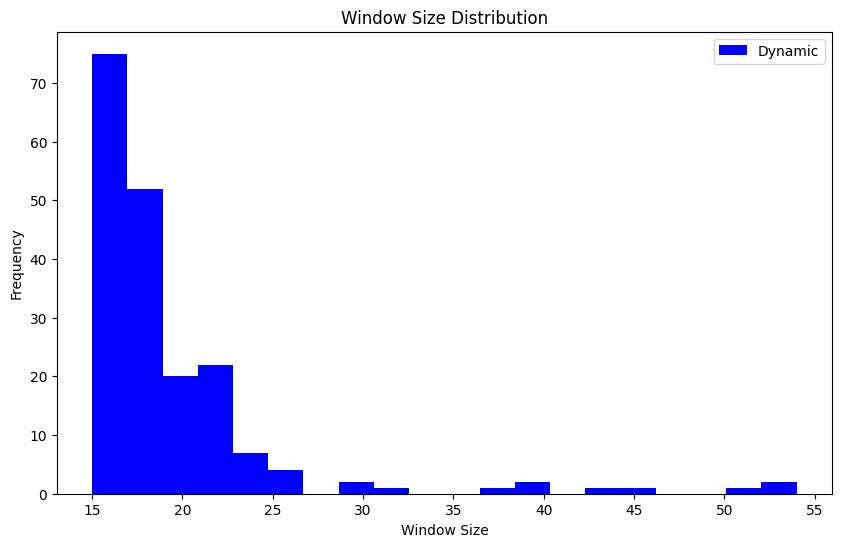

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(dsa.window_sizes, label='Dynamic', bins=20, color='blue')
plt.xlabel('Window Size')
plt.ylabel('Frequency')
plt.title('Window Size Distribution')
plt.legend()
plt.show()


In [22]:
weight_df = pd.DataFrame(dsa.portfolio_weights).T
tic_df.index = pd.to_datetime(tic_df.index)
returns_df.index = pd.to_datetime(returns_df.index)
weight_df.index = pd.to_datetime(weight_df.index)
print(weight_df.shape)
start_dt = pd.to_datetime(weight_df.index[0])
target_index = returns_df.loc[start_dt:].index  # 라벨 슬라이싱
weight_df = weight_df.reindex(target_index, method='ffill').dropna()

print(weight_df.shape)

new_returns_df = pd.DataFrame()
for (idx1, row1), (idx2, row2) in zip(tic_df.iloc[:-1, :].iterrows(), tic_df.iloc[1:, :].iterrows()):
    new_returns_df = pd.concat([new_returns_df, pd.DataFrame(returns_df.loc[row1.name:row2.name-pd.Timedelta(days=1), row1].values)], axis=0)

row = tic_df.iloc[-1, :]
new_returns_df = pd.concat([new_returns_df, pd.DataFrame(returns_df.loc[row.name:, row].values)], axis=0)

new_returns_df.index = weight_df.index
returns_df_winsorized = new_returns_df.clip(lower=-1, upper=1)
print(new_returns_df.shape)
tic_df = tic_df.reindex(target_index, method='ffill').dropna()
weight_df.to_csv('data/weight_df.csv')
tic_df.to_csv('data/tic_df.csv')
returns_df_winsorized.to_csv('data/returns_df.csv')

(191, 20)
(3648, 20)
(3648, 20)
